In [75]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import dask.array as da
from scipy.stats import chi2_contingency
from dask.array.stats import chisquare
from scipy.stats import chisquare, chi2_contingency

In [ ]:
# Reading the data using dask

sample = dd.read_csv('new_train_sample.csv', dtype={'ActionGranular': 'object',
       'ActionGrouped': 'object',
       'AntispamDirection': 'object',
       'ResourceType': 'object',
       'Roles': 'object',
       'ThreatFamily': 'object'})

In [77]:
sample.head()

,Unnamed: 0,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,5172780,1709396985476,26,18583,687462,2024-06-06T05:56:47.000Z,31,813,Malware,NaN,...,NaN,NaN,5,66,NaN,Suspicious,Malicious,242,1445,10630
1,8470561,927712939180,33,5065,3990,2024-06-03T10:45:09.000Z,38,25,Impact,NaN,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,5897583,1090921697002,201,150787,807590,2024-06-13T03:36:40.000Z,419,444,Execution,T1047;T1059;T1053;T1569;T1059.001;T1053.002;T1...,...,NaN,Destination,5,66,NaN,NaN,NaN,242,1445,10630
3,3288552,1434519079555,204,108287,28575,2024-06-08T16:54:57.000Z,44,1233,SuspiciousActivity,NaN,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,4060961,1005022347708,54,528202,1458226,2024-06-09T02:48:01.000Z,102,58829,Exfiltration,NaN,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [78]:
sample.columns

Index(['Unnamed: 0', 'Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp',
       'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques',
       'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType',
       'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid',
       'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName',
       'NetworkMessageId', 'EmailClusterId', 'RegistryKey',
       'RegistryValueName', 'RegistryValueData', 'ApplicationId',
       'ApplicationName', 'OAuthApplicationId', 'ThreatFamily', 'FileName',
       'FolderPath', 'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily',
       'OSVersion', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict',
       'CountryCode', 'State', 'City'],
      dtype='object')

In [79]:
sample.shape[0].compute(), sample.shape[1]

(4758418, 46)

In [80]:
sample= sample.drop(['Unnamed: 0'],axis=1)

In [81]:
sample.info()

<class 'dask_expr.DataFrame'>
Columns: 45 entries, Id to City
dtypes: float64(1), int64(30), string(14)

In [82]:
sample.isnull().sum().compute()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2733136
IncidentGrade           25775
ActionGrouped         4730205
ActionGranular        4730205
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4710241
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4721038
FileName                    0
FolderPath

In [83]:
# Droping columns that have more null values

sample = sample.drop(['MitreTechniques','ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType','Roles','AntispamDirection','SuspicionLevel','LastVerdict'], axis=1)

In [84]:
sample = sample.drop(['Id'], axis=1)

In [85]:
# deleting null values 
sample = sample.dropna(subset=['IncidentGrade'])

In [86]:
sample.isnull().sum().compute()

OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [87]:
# Moving target column to the end
column_to_move = 'IncidentGrade'
new_order = [col for col in sample.columns if col != column_to_move] + [column_to_move]
sample = sample[new_order]

In [88]:
sample.head(10)

,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,EntityType,EvidenceRole,DeviceId,...,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,IncidentGrade
0,26,18583,687462,2024-06-06T05:56:47.000Z,31,813,Malware,File,Related,98799,...,881,4132,4227,3586,5,66,242,1445,10630,BenignPositive
1,33,5065,3990,2024-06-03T10:45:09.000Z,38,25,Impact,Machine,Impacted,98799,...,881,289573,117668,3586,5,66,242,1445,10630,BenignPositive
2,201,150787,807590,2024-06-13T03:36:40.000Z,419,444,Execution,Machine,Impacted,98799,...,881,289573,117668,3586,5,66,242,1445,10630,BenignPositive
3,204,108287,28575,2024-06-08T16:54:57.000Z,44,1233,SuspiciousActivity,File,Related,98799,...,881,97007,9177,3586,5,66,242,1445,10630,TruePositive
4,54,528202,1458226,2024-06-09T02:48:01.000Z,102,58829,Exfiltration,File,Impacted,98799,...,881,39978,114449,3586,5,66,242,1445,10630,BenignPositive
5,7,3645,852,2024-05-25T07:02:28.000Z,21,1040,Impact,Ip,Related,98799,...,881,289573,117668,3586,5,66,242,1445,10630,FalsePositive
6,0,84,104970,2024-06-05T15:42:13.000Z,0,0,InitialAccess,CloudLogonSession,Related,98799,...,881,289573,117668,3586,5,66,242,1445,10630,TruePositive
7,8,9452,142992,2024-06-10T20:13:37.000Z,3,4,SuspiciousActivity,Ip,Related,98799,...,881,289573,117668,3586,5,66,242,1445,10630,TruePositive
8,48,450962,586926,2024-06-12T20:21:09.000Z,81,802,SuspiciousActivity,User,Impacted,98799,...,881,289573,117668,3586,5,66,242,1445,10630,BenignPositive
9,0,262,385477,2024-06-06T01:41:40.000Z,0,0,InitialAccess,Ip,Related,98799,...,881,289573,117668,3586,5,66,1,0,0,TruePositive


In [89]:
sample.columns

Index(['OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'IncidentGrade'],
      dtype='object')

In [90]:
# EDA PROCESS

cat_cols = sample.select_dtypes(include=['string']).columns
cat_cols

Index(['Timestamp', 'Category', 'EntityType', 'EvidenceRole', 'IncidentGrade'], dtype='object')

In [91]:
sample['Category'].value_counts().compute()

Category
Collection                7234
InitialAccess          2142820
LateralMovement          20587
Exfiltration            775297
Impact                  375431
DefenseEvasion           23205
Weaponization                2
Malware                  71546
UnwantedSoftware          8992
Execution               133519
Exploit                   2339
Discovery                64051
CredentialAccess        150268
PrivilegeEscalation       2379
WebExploit                  17
Ransomware                8685
Persistence              36304
SuspiciousActivity      497316
CommandAndControl       412454
CredentialStealing         197
Name: count, dtype: int64

In [92]:
cate_col_counts = sample['Category'].value_counts().compute()

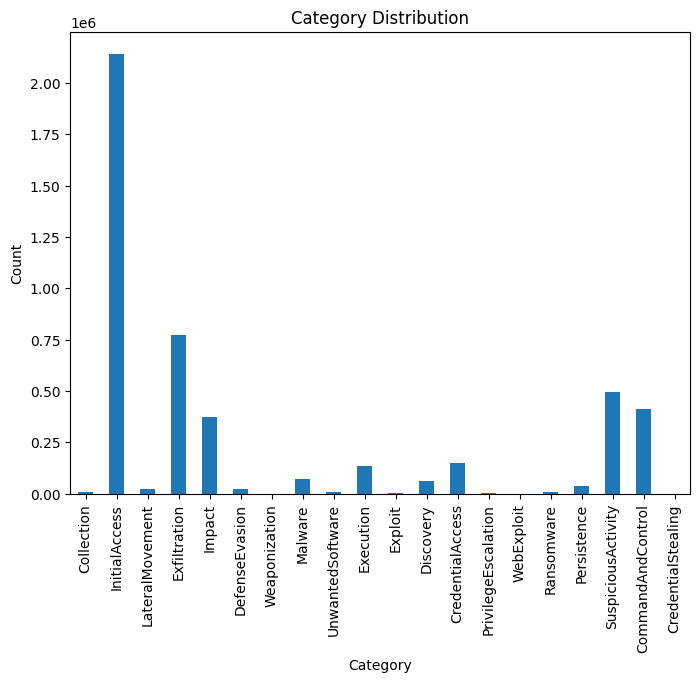

In [93]:
# Plot for Category distribution

fig, ax = plt.subplots(figsize=(8, 6))
cate_col_counts.plot(kind='bar', ax=ax, title='Category Distribution')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Category Distribution')
plt.show()

In [94]:
sample['Timestamp'].head(1)

0    2024-06-06T05:56:47.000Z
Name: Timestamp, dtype: object

In [95]:
# Extracting only date 
sample['Timestamp']= sample['Timestamp'].str.extract(r'(\d{4}-\d{2}-\d{2})', expand=False)

In [96]:
# Converting into datetime format
sample['Timestamp']= dd.to_datetime(sample['Timestamp'],  format='%Y-%m-%d')

In [97]:
sample['EntityType'].value_counts().compute()

EntityType
Nic                           25
BlobContainer                156
AmazonResource                 2
GoogleCloudResource            6
ActiveDirectoryDomain          6
Ip                       1090519
Malware                     1294
CloudApplication          108318
KubernetesCluster              2
RegistryKey                 3690
File                      344917
IoTDevice                     16
CloudLogonSession         106696
ContainerRegistry              1
GenericEntity               2098
KubernetesNamespace            1
Mailbox                   239852
User                      943168
Blob                         117
MailCluster               112144
SecurityGroup                719
MailboxConfiguration         114
Machine                   348833
AzureResource               4100
CloudLogonRequest         319092
RegistryValue               5598
Url                       341007
MailMessage               586318
Process                   172561
KubernetesPod                  2

In [98]:
Entity_counts = sample['EntityType'].value_counts().compute()

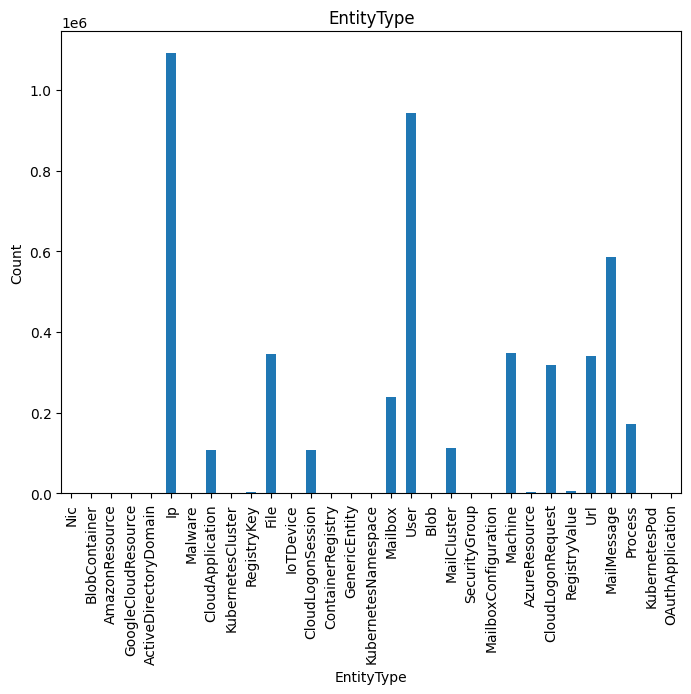

In [99]:
#Plot for entity distribution

fig, ax = plt.subplots(figsize=(8, 6))
Entity_counts.plot(kind='bar', ax=ax, title='EntityType', rot=90)
ax.set_ylabel('Count')
plt.show()

In [100]:
EvidenceRole_counts = sample['EvidenceRole'].value_counts().compute()

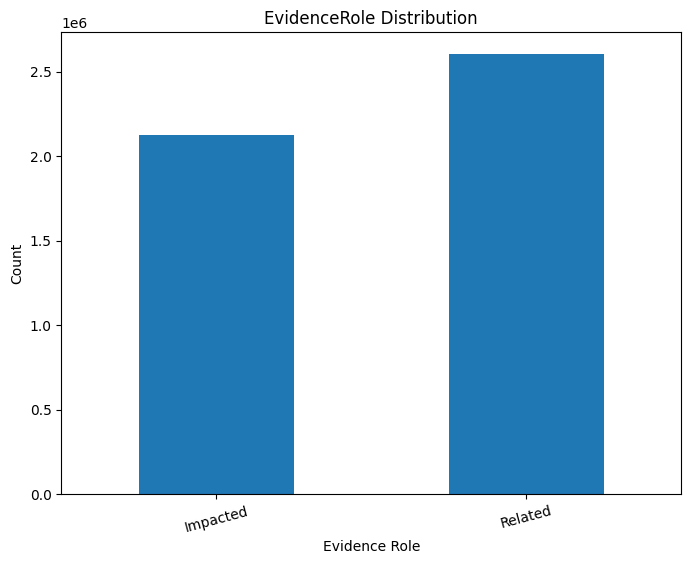

In [101]:
# Evidence role distribution
fig, ax = plt.subplots(figsize=(8, 6))

EvidenceRole_counts.plot(kind='bar', ax=ax, title='EvidenceRole Distribution', rot=15)
ax.set_xlabel('Evidence Role')
ax.set_ylabel('Count')
plt.show()

In [102]:
IncidentGrade_counts = sample['IncidentGrade'].value_counts().compute()

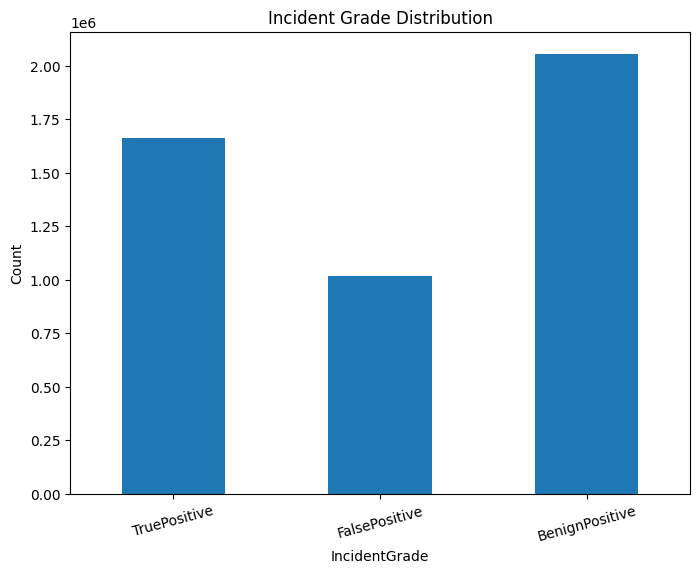

In [103]:
# Ploting for target column distribution

fig, ax = plt.subplots(figsize=(8, 6))

IncidentGrade_counts.plot(kind='bar', ax=ax, title='Incident Grade Distribution', rot=15)
ax.set_ylabel('Count')
ax.set_title('Incident Grade Distribution')
plt.show()

In [104]:
sample.groupby(['Category', 'IncidentGrade']).size().compute()

Category             IncidentGrade 
Collection           FalsePositive        3527
CommandAndControl    BenignPositive     281401
                     TruePositive        58313
CredentialAccess     BenignPositive      59418
                     TruePositive        55058
DefenseEvasion       BenignPositive      10814
                     TruePositive         5343
Discovery            FalsePositive       17138
Execution            FalsePositive       44228
Exfiltration         BenignPositive     540337
                     TruePositive        50534
Exploit              FalsePositive         328
Impact               BenignPositive     168399
                     TruePositive       121637
InitialAccess        FalsePositive      477063
LateralMovement      FalsePositive        4459
Malware              FalsePositive        9647
Persistence          BenignPositive      28031
                     TruePositive         1763
PrivilegeEscalation  BenignPositive       2114
Ransomware           Ben

In [105]:
cat_grouped = sample.groupby(['Category', 'IncidentGrade']).size().compute().values

tot_len = len(sample)
print(tot_len)

4732643


In [106]:
expected = [tot_len / len(cat_grouped)] * len(cat_grouped)

# performing chi-square test
chi2_stat, p_value = chisquare(da.from_array(cat_grouped), f_exp=da.from_array(expected))

print(f"Chi-square statistic: {chi2_stat:.6f}")
print(f"P-value: {p_value:.6f}")

# Both coluns has significant correlation

Chi-square statistic: 23977532.833118
P-value: 0.000000


In [107]:
sample.groupby(['EntityType', 'IncidentGrade']).size().compute()

EntityType             IncidentGrade 
ActiveDirectoryDomain  FalsePositive        5
AzureResource          BenignPositive    3183
                       TruePositive       522
Blob                   FalsePositive       96
BlobContainer          FalsePositive      123
                                         ... 
MailboxConfiguration   BenignPositive      32
ActiveDirectoryDomain  BenignPositive       1
Blob                   TruePositive         2
KubernetesCluster      BenignPositive       1
KubernetesPod          FalsePositive        1
Length: 77, dtype: int64

In [108]:
entity_grouped = sample.groupby(['EntityType', 'IncidentGrade']).size().compute().values

In [109]:
expected= [tot_len / len(entity_grouped)] * len(entity_grouped)

#performing chi square test

chi2_stat, p_value= chisquare(da.from_array(entity_grouped), da.from_array(expected))

print(f"Chi-square statistic: {chi2_stat:.6f}")
print(f"P-value: {p_value:.6f}")

# Both coluns has significant correlation btw

Chi-square statistic: 14803971.864897
P-value: 0.000000


In [110]:
sample.groupby(['EvidenceRole', 'IncidentGrade']).size().compute()

EvidenceRole  IncidentGrade 
Impacted      FalsePositive      479485
Related       BenignPositive     978371
              TruePositive      1089359
Impacted      BenignPositive    1076403
              TruePositive       572728
Related       FalsePositive      536297
dtype: int64

In [111]:
Evidence_grouped = sample.groupby(['EvidenceRole', 'IncidentGrade']).size().compute().values

In [112]:
expected = [tot_len / len(Evidence_grouped)] * len(Evidence_grouped)

# perform chi-square test
chi2_stat, p_value = chisquare(da.from_array(Evidence_grouped), da.from_array(expected))

print(f"Chi-square statistic: {chi2_stat:.6f}")
print(f"P-value: {p_value:.6f}")

# Both coluns has significant correlation btw

Chi-square statistic: 526271.262938
P-value: 0.000000


In [113]:
sample.select_dtypes(include=['int64']).columns

Index(['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [114]:
sample['State'].min().compute()

np.int64(0)

In [115]:
sample['State'].max().compute()

np.int64(1445)

In [116]:
rangev = [sample['State'].min().compute(), sample['State'].max().compute()]

In [117]:
rangev

[np.int64(0), np.int64(1445)]

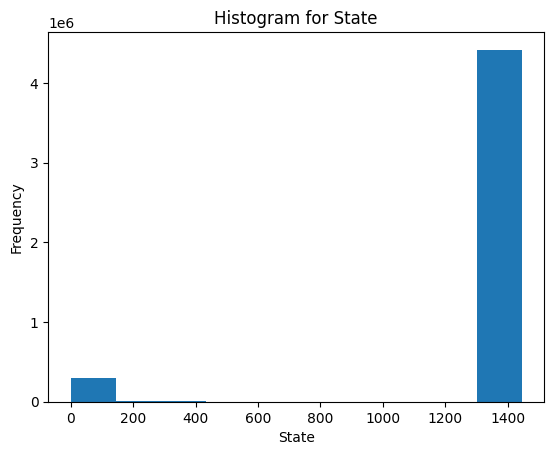

In [118]:
# histogram values
hist, bin_edges = da.histogram(sample['State'].values, bins=10, range=rangev)
hist_values = hist.compute()

# Plotting the histogram
plt.figure()
plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
plt.title(f'Histogram for State')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.show()


In [119]:
rangev = [sample['NetworkMessageId'].min().compute(),sample['NetworkMessageId'].max().compute()]

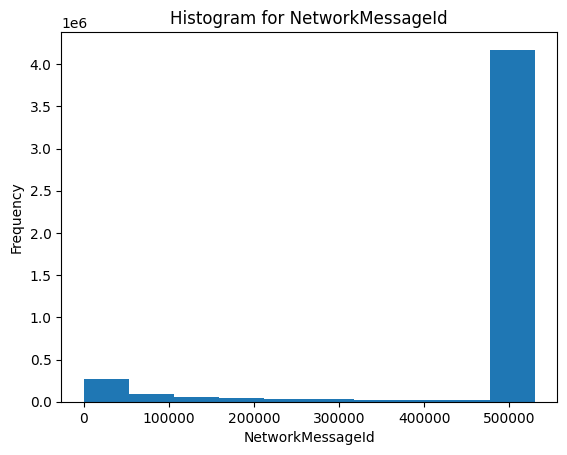

In [120]:
hist, bin_edges = da.histogram(sample['NetworkMessageId'].values, bins=10, range=rangev)
hist_values = hist.compute()

#Plot for Network Message Id

plt.figure()
plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
plt.title(f'Histogram for NetworkMessageId')
plt.xlabel('NetworkMessageId')
plt.ylabel('Frequency')
plt.show()

In [121]:
rangev = [sample['CountryCode'].min().compute(), sample['CountryCode'].max().compute()]

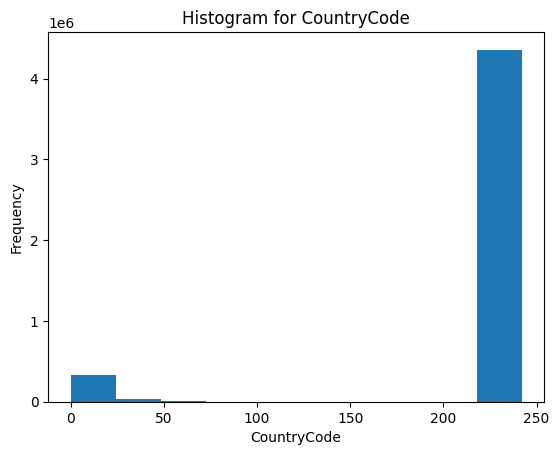

In [122]:
hist, bin_edges = da.histogram(sample['CountryCode'].values, bins=10, range=rangev)
hist_values = hist.compute()

#Plot for Countrycode
plt.figure()
plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
plt.title(f'Histogram for CountryCode')
plt.xlabel('CountryCode')
plt.ylabel('Frequency')
plt.show()

In [123]:
rangev = [sample['AlertTitle'].min().compute(),sample['AlertTitle'].max().compute()]

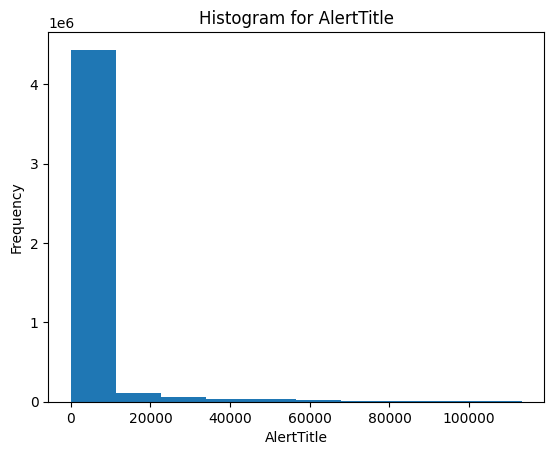

In [124]:
hist, bin_edges = da.histogram(sample['AlertTitle'].values, bins=10, range=rangev)
hist_values = hist.compute()

# Histogram plot for Alertitle


plt.figure()
plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
plt.title(f'Histogram for AlertTitle')
plt.xlabel('AlertTitle')
plt.ylabel('Frequency')
plt.show()